# 1. Data Collection

### 1.1 Get the List of Animes

In [1]:
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
import urllib.request 
import os
import codecs
import pandas as pd
from datetime import datetime
import time
import csv

Downloading each anime's url to a single text file

In [24]:
links_text = open("links.txt", "w")
for page in tqdm(range(0, 400)):
    url = 'https://myanimelist.net/topanime.php?limit=' + str(page * 50)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    for tag in soup.find_all('tr'):
        links = tag.find_all('a')
        for link in links:        
            if type(link.get('id')) == str and len(link.contents[0]) > 1:
                data = link.get('href')
                links_text.write(data)
                links_text.write("\n")
links_text.close()

100%|██████████| 400/400 [05:44<00:00,  1.16it/s]


Reading how many lines in the text file

In [25]:
file = open("links.txt", "r")
line_count = 0
for line in file:
    if line != "\n":
        line_count += 1
file.close()

print('There are total {} lines in this file.'.format(line_count))


There are total 19124 lines in this file.


### 1.2 Crawl the Animes

In [161]:
directory = 'html_pages'
parent_dir = "/Users/onurergun/Desktop/ADM-HW3"
path = os.path.join(parent_dir, directory)
os.mkdir(path)

Creating subfolders for each page of the list </br>
After creating the subfolders, we add each html file to corresponding page number folder.

In [221]:
# creating the directory for html pages to be downloaded
directory = 'html_pages'
file_read = open('links.txt', 'r')
anime_urls_list = file_read.readlines()
file_read.close()

for i in range(1,401):
    # reading each page from 1 to 400
    html_page_name = 'page'+str(i)
    os.makedirs(os.path.join(directory, html_page_name ))
    directory_subfolder = directory+'/'+html_page_name+'/'
    
    # reading each anime on the list from 1 to 51
    for j in range(1,51):
        anime_num = 50*(i-1)+j
        html_file_name = directory_subfolder+'article_'+str(anime_num)+'.html'
        temp_text = open(html_file_name, "w")
        url = anime_urls_list[(anime_num-1)].encode('ascii','backslashreplace').decode('utf-8')
        urllib.request.urlretrieve(url,html_file_name)
        temp_text.close()

### 1.3 Parse downloaded pages


In [5]:
animeTitle = []
animeType = []
animeNumEpisode = []
releaseDate = []
endDate = []
animeNumMembers = []
animeScore = []
animeUsers = []
animeRank = []
animePopularity = []
animeDescription = []
animeRelated = []
animeCharacters = []
animeVoices = []
animeStaff = []
directory = 'html_pages'

In [6]:
def parse_function(html_file_path):
    """
    Function that extracts anime's informations.
    Input: path (a string that is related to the position of each anime page in the folder tree)
    Output: a list of lists with all the informations mentioned above
    """
    # take article_i.html from the directory 
    soup = BeautifulSoup(open(html_file_path), "html.parser")
    divs = soup.find_all("div", {"class": "spaceit_pad"})
    try:
        animeTitle.append(str(soup.find_all('strong')[0].contents[0]))
    except:
        animeTitle.append('')

    for div in divs:
        spans = div.find_all("span")
        for span in spans:
            # TYPES
            if span.contents[0] == 'Type:':
                try:
                    animeType.append(str(div.find_all('a')[0].contents[0]))
                except:
                    animeType.append('NA')
            # NUMBER OF EPISODES
            if span.contents[0] == 'Episodes:':
                try: 
                    animeNumEpisode.append(int(div.contents[2]))
                except:
                    animeNumEpisode.append(0)
            # DATES
            if span.contents[0] == 'Aired:':
                try:
                    if len(div.contents[2]) > 21:
                        release = pd.to_datetime(div.contents[2][1:16]).to_pydatetime().strftime('%m/%d/%Y')
                        releaseDate.append(release)
                        end = pd.to_datetime(div.contents[2][1:16]).to_pydatetime().strftime('%m/%d/%Y')
                        endDate.append(end)
                    else:
                        release = pd.to_datetime(div.contents[2][1:16]).to_pydatetime().strftime('%m/%d/%Y')
                        releaseDate.append(release)
                        endDate.append('-')
                except:
                        releaseDate.append('')
                        endDate.append('')

    divs = soup.find_all("div", {"class": "stats-block po-r clearfix"})
    for div in divs:
        
        # MEMBERS
        members = div.find_all("span", {"class": "numbers members"})
        animeNumMembers.append(int(members[0].contents[1].contents[0].replace(',', '')))
        
        
        # SCORE
        # center of the html page
        rating=soup.find(name="div",attrs={"class":"fl-l score"})
        try:        
            animeScore.append(float(rating.text.strip()))
        except:
            animeScore.append(None)

     
        # USERS
        users = div.find_all("div", {"class": "fl-l score"})
        # here we we eliminate the word 'user '   
        # that is why there is the [:-6] part
        # we also replace the comma divisor
        try:
            animeUsers.append(int(users[0]['data-user'][:-6].replace(',', '')))
        except:
            animeUsers.append(0)


        # RANK
        rank = div.find_all("span", {"class": "numbers ranked"})
        try:
            animeRank.append(int(rank[0].contents[1].contents[0][1:]))
        except:
            animeRank.append(None)

        # POPULARITY
        popularity = div.find_all("span", {"class": "numbers popularity"})
        animePopularity.append(int(popularity[0].contents[1].contents[0][1:]))
    
    # DESCRIPTION
    # center of the html page
    animeDescription.append(soup.find_all("p", itemprop = "description")[0].text.strip().replace('\n', '').replace('  ', ''))


    # RELATED 
    related = soup.find_all("table", {"class": "anime_detail_related_anime"})
    if(len(related)!=0):
        x = []
        y = []
        for tr in related:
            td = tr.find_all("td")
            for i in range(0, len(td), 2):
                x.append(td[i].contents[0])
                t = td[i+1].find_all("a")
                if(len(t[0].contents)!=0):  
                    y.append(t[0].contents[0])
                else:
                    y.append(' ')
            animeRelated.append('\n'.join([f'{x} {y}' for x, y in dict(zip(x, y)).items()]).split('\n'))
    else:
        animeRelated.append(' ')
    
    # CHARACTERS
    try:
        characters = soup.find_all("div", {"class": "detail-characters-list clearfix"})
        chars = characters[0].find_all("h3", {"class": "h3_characters_voice_actors"})
        x = []
        for i in chars:
            x.append(i.contents[0].contents[0])
        animeCharacters.append(x)
    except:
        animeCharacters.append(" ")
    
    
   # VOICES
    try:
        voices = characters[0].find_all("td", {"class": "va-t ar pl4 pr4"})
        y = []
        for i in voices:
            y.append(i.contents[1].contents[0])
        animeVoices.append(y)
    except:
        animeVoices.append(" ")
    
    # STAFF
    try:
        staff = soup.find_all("div", {"class": "detail-characters-list clearfix"})
        staff = staff[1].find_all("td")
        x = []
        y = []
        for i in range(1, len(staff), 2):
            x.append(staff[i].contents[1].contents[0])
            y.append(staff[i].find_all("small")[0].contents[0])
        animeStaff.append([list(i) for i in list(zip(x,y))])
    
    except:
        animeStaff.append(" ")
               

In [7]:
os.makedirs('tsv_files')

In [8]:
# function to create tsv files 
def tsv_create(i):
    tsv_columns = ['animeTitle','animeType','animeNumEpisode','releaseDate','endDate','animeNumMembers','animeScore',
                  'animeUsers','animeRank','animePopularity','animeDescription','animeRelated','animeCharacters',
                  'animeVoices','animeStaff']
    # each tsv files are read and written with the respective column names
    data = zip([animeTitle[i-1]],[animeType[i-1]],[animeNumEpisode[i-1]],[releaseDate[i-1]],[endDate[i-1]],[animeNumMembers[i-1]],[animeScore[i-1]],[animeUsers[i-1]],[animeRank[i-1]],[animePopularity[i-1]],[animeDescription[i-1]],[animeRelated[i-1]],[animeCharacters[i-1]],[animeVoices[i-1]],[animeStaff[i-1]])
    # opening the relative specific tsv file
    tsv_file_name = 'tsv_files/anime_'+str(i)+'.tsv'
    with open(tsv_file_name, 'w', newline='') as f_output:
        # creating the tsv 
        tsv_output = csv.writer(f_output, delimiter='\t')
        tsv_output.writerow(tsv_columns)
        for title,typ,numEp,relD,endD,numMem,score,user,rank,popularity,descr,relat,charac,voices,staff in data:
                tsv_output.writerow([title,typ,numEp,relD,endD,numMem,score,user,rank,popularity,descr,relat,charac,voices,staff])


In [9]:
for i in range(1,384):
    html_page_name = 'page'+str(i)
    directory_subfolder = directory+'/'+html_page_name+'/'
    if(i!=383):
        # 383th page has less than 50 animes thats why
        # on the else block we only iterate until 25
        for j in range(1,51):
            # getting the anime index number according to which page we are in, i is the page, and j is the which jth element
            # of the page we are in 
            anime_num = 50*(i-1)+j
            # from the number we get we create the html file in article_i form
            html_file_path = directory_subfolder+'article_'+str(anime_num)+'.html'
            soup = BeautifulSoup(open(html_file_path), "html.parser")
            parse_function(html_file_path)
            # calling the tsv create function to create tsv 
            tsv_create(anime_num)
    else:
        for j in range(1,25):
            anime_num = 50*(i-1)+j
            html_file_path = directory_subfolder+'article_'+str(anime_num)+'.html'
            soup = BeautifulSoup(open(html_file_path), "html.parser")
            parse_function(html_file_path)
            tsv_create(anime_num)

# 2. Search Engine


### Preprocessing of the information

In [2]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import numpy as np
import json
import string

In [3]:
# getting the english stopwords list
stop = stopwords.words('english')
# stemming object from porter stemmer library
porter_stemmer = PorterStemmer()

In [4]:
def stem_sentences(sentence):
    # function gets the sentence and then splits into a words
    tokens = sentence.split()
    # each word are considered as tokens and we stem them accordingly using porter stemmer
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    # after we join all the list to a str and return it
    return ' '.join(stemmed_tokens)


In [5]:
# creatingg an empty list for animeTitles and animeDescriptions
animeTitle_list = []
animeDescription_list = []

In [6]:
# creating a lists from tsv files
for i in range(0,19124):
    # 19124 is the number of animes we have
    # we open them accordingly and save it to a list we've just created 
    anime_tsv = open('tsv_files/anime_'+str(i+1)+'.tsv', 'r',encoding="utf8")
    data=pd.read_table(anime_tsv)[['animeTitle','animeDescription']]
    data['animeTitle'] = data['animeTitle'].astype(str)
    data['animeDescription'] = data['animeDescription'].astype(str)
    # appending the titles and animes to a list
    animeTitle_list.append(str(data.animeTitle[0]))
    animeDescription_list.append(str(data.animeDescription[0]))

In [7]:
# concetenating lists to create a dataframe
anime_df = pd.DataFrame(np.column_stack([animeTitle_list, animeDescription_list]), 
                               columns=['animeTitle', 'animeDescription'])

Checking if there is a mismatch on the dataframe

In [8]:
# removing stopwords from the dataframe
anime_df['animeDescription']  = anime_df['animeDescription'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# removing punctuations from the dataframe
anime_df['animeDescription'] = anime_df['animeDescription'].str.replace('[^\w\s]',' ')

# stemming the dataframe 
anime_df['animeDescription'] = anime_df['animeDescription'].apply(stem_sentences)


<ipython-input-8-b8d327cbacaf>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  anime_df['animeDescription'] = anime_df['animeDescription'].str.replace('[^\w\s]',' ')


In [9]:
# creating a words list inside synopsis of each anime
words_list = ' '.join([i for i in anime_df['animeDescription']]).split()

### 2.1. Conjunctive query


In [201]:
# removing the duplicate words from the words list
words_dict = set(words_list)

# Assign a unique integer id to each non duplicate words
vocabulary = {}
# by doing this, we are gonna create a vocabulary dictionary, with each row has unique id key, assigned
# to a non duplicate word inside all of the lists
i=1
for word in words_dict:
    # adding word to i num key
    vocabulary.update({i:word})
    # increasing the key number 
    i+=1

#### 2.1.1 Create your index!


Creating the vocabulary json file that we store for each nun duplicate words with id number 

In [156]:
# creating a vocabulary json file and assinging all the values inside
# vocabulary dictionary to a json file
# so that we dont have to create vocabulary dictionary everytime we run the project
with open("vocabulary.json", "w") as file:
    json.dump(vocabulary, file)
file.close()

Creating an inverted index 

In [157]:
# creating an empty dictionary to create a inverted index json file
inverted_dict = {}

In [158]:
# reading vocabulary json
with open('vocabulary.json') as data_file:  
    # storing the json data inside a data object
    data = json.load(data_file)
    # reading each key and value pairs inside vocabulary json file
    for key, value in tqdm(data.items()):
        # creating an empty list for inverted json file
        inverted_list = []
        for i in range(0,len(anime_df)):
            # parsing the synopsis sentences into words
            if(value in anime_df['animeDescription'][i].split()):
                # if the value of vocabulary json is inside the anime synopsis
                # add anime name that has the value to a list 
                anime_name = 'anime_'+str(i+1)
                inverted_list.append(anime_name)
                # update the dict with the key and inverted list we've just created
                inverted_dict.update({key:inverted_list})


100%|██████████| 36793/36793 [1:17:26<00:00,  7.92it/s]   


Saving the inverted index dictionary to a json file

In [159]:
# create an inverted.json file and assign inverted_dict
with open("inverted.json", "w") as file:
    json.dump(inverted_dict, file)
file.close()

#### 2.1.2 Execute the query


In [10]:
def find_query(query_list):
    # empty list to assign values at the end which has same values with the query
    anime_query_list = []
    # iterate over the query list, as on every word
    for word in query_list:
        # open the vocab json file
        with open('vocabulary.json') as data_file:
            data = json.load(data_file)
            for key, value in data.items():
                # if the word inside query matches the value in the vocabulary json
                if(word == value):
                    # open the inverted json and match the key with it
                    with open('inverted.json') as inverted_file:
                        inverted_data = json.load(inverted_file)
                        for inv_key, inv_value in inverted_data.items():
                            # if the keys are matching, then we have the same word query
                            if(key == inv_key):
                                # appending the value to a list if has the specific query word
                                anime_query_list.append(inv_value)
    
    # creating a list from all animes including duplicate ones
    anime_list = []
    for i in range(len(anime_query_list)):
        for j in range(len(anime_query_list[i])):
            anime_list.append(anime_query_list[i][j])
    
    # creating a set to find non duplicate anime files
    anime_query_set_list = list(set(anime_list))
    # creating an empty list to store the final anime list which has all the input queries 
    anime_final_list = []
    
    # counting the occurences of each anime with the length of the total query
    # if its equal to total len, then each word in the query appears on the anime description
    for anime in anime_query_set_list:
        if(anime_list.count(anime) == len(anime_query_list)):
            anime_final_list.append(anime)
    # returning a final anime list which includes every word inside the query        
    return anime_final_list

In [11]:
def create_query_anime_df(anime_list):
    # creating lists for animes
    animeTitle_list = []
    animeDescription_list = []
    animeUrl_list = []
    # to creat dataframe, we first create empty lists representing each column for the dataframe
    
    # assigning tsv values from the animes to lists we've just created 
    for anime in anime_list:
        anime_tsv = open('tsv_files/'+anime+'.tsv', 'r',encoding="utf8")
        data=pd.read_table(anime_tsv)[['animeTitle','animeDescription']]
        data['animeTitle'] = data['animeTitle'].astype(str)
        data['animeDescription'] = data['animeDescription'].astype(str)
        animeTitle_list.append(str(data.animeTitle[0]))
        animeDescription_list.append(str(data.animeDescription[0]))

    # reading text file url lines to a list
    f=open('links.txt')
    url_lines=f.readlines()
    f.close()

    # creating a for loop to iterate over each anime we have on the anime_list
    for anime in anime_list:
        # getting the int value from the anime name
        anime_num=(int(anime.split("anime_",1)[1]))
        # finding the corresponding line from the links.txt and assigning it to a list
        animeUrl_list.append(url_lines[(anime_num-1)])

    # creating the dataframe from lists and returning it
    return pd.DataFrame(np.column_stack([animeTitle_list, animeDescription_list, animeUrl_list]), 
                                   columns=['animeTitle', 'animeDescription', 'Url'])

In [12]:
# getting an input from the user
query = input('Enter your search:')

Enter your search: saiyan race


In [13]:
# stemming, removing stop words and punctuations from the input string
query = ' '.join([word for word in query.split() if word not in stop])
query = query.translate(str.maketrans('', '', string.punctuation))
query = stem_sentences(query)
# creating a list from the input query
query_list = query.split()
# getting the list of animes which has the query
anime_list = find_query(query_list)

In [14]:
# getting the anime dataframe from our query
query_anime_df = create_query_anime_df(anime_list)

In [15]:
query_anime_df

,animeTitle,animeDescription,Url
0,Dragon Ball Z Special 1: Tatta Hitori no Saish...,"Bardock, Son Goku's father, is a low-ranking S...",https://myanimelist.net/anime/986/Dragon_Ball_...
1,Dragon Ball Kai,"Five years after the events of Dragon Ball, ma...",https://myanimelist.net/anime/6033/Dragon_Ball...
2,Dragon Ball Z,Five years after winning the World Martial Art...,https://myanimelist.net/anime/813/Dragon_Ball_Z\n
3,Dragon Ball Super: Broly,"Forty-one years ago on Planet Vegeta, home of ...",https://myanimelist.net/anime/36946/Dragon_Bal...


### 2.2 Conjunctive query & Ranking score


In [26]:
import math

### 2.2.1 Inverted index

finding the term frequency

In [49]:
def find_tf(word, anime_num):
    # finding the number of specific word in a document
    document = anime_df['animeDescription'][anime_num-1].split()
    tf_counter = 0
    for i in range(len(document)):
        if(document[i] == word):
            tf_counter+=1
    # calculating the term frequency aka tf
    tf = tf_counter / len(document)
    return tf

finding the document frequency

In [13]:
def find_df(word):
    # finding the number of occurences of the word in all the documents
    df_counter = 0
    for i in range(len(anime_df)):
        document = anime_df['animeDescription'][i].split()
        for i in range(len(document)):
            if(document[i] == word):
                df_counter+=1 # df counter is the document frequency aka df
    return df_counter

In [14]:
with open('vocabulary.json') as word_file:
    data_vocab = json.load(word_file)
    word_file.close()

In [56]:
# creating the last version of the tfidf dict
tfidf_last_dict = {}

In [57]:
with open('inverted.json') as data_file:    
    data = json.load(data_file)
    data_file.close()
    
with open('vocabulary.json') as word_file:
    data_vocab = json.load(word_file)
    word_file.close()
    
for i in tqdm(range(len(data))):
    # reading each anime to a list that contains a specific word
    word = data_vocab[str(i+1)] # getting the specific word from vocabulary json
    anime_list = data[str(i+1)] # getting all animes related to a specific word from inverted.json
    tfidf_list = []
    for anime in anime_list:
        tfidf_dict = {}
        # getting the anime num from the tsv file name
        anime_num=(int(anime.split("anime_",1)[1]))
        # finding the tf value
        tf = find_tf(word, anime_num) 
        # finding the df value
        df_counter = find_df(word)
        # inverse document frequency aka idf is a log of total documents divided by df+1
        # idf = log(N/(df + 1))
        idf = math.log((len(anime_df) / df_counter+1), 10)
        # calculating the tfidf number by multiplication
        tfidf = tf * idf
        # creating a dictionary for each anime - tfidf pairs
        tfidf_dict.update({anime:tfidf})
        tfidf_list.append(tfidf_dict)
    tfidf_last_dict.update({i+1:tfidf_list})

100%|██████████| 36793/36793 [25:31:13<00:00,  2.50s/it]       


In [ ]:
# creating the json file
with open("tfidf.json", "w") as file:
    json.dump(tfidf_last_dict, file)
file.close()

### 2.2.2 Execute the query


In [71]:
import re
from collections import Counter

In [72]:
def get_cosine(vec1, vec2):
    # the two string vectors intersection and numerator calculation
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    # summing up the values from the vectors
    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    # calculating the denominator for the cosine
    denominator = math.sqrt(sum1) * math.sqrt(sum2)
    
    if not denominator:
        return 0.0
    else:
        # return the cosine
        return float(numerator) / denominator


def text_to_vector(text):
    # getting a string value and turning it to a vector 
    words = WORD.findall(text)
    return Counter(words)

In [85]:
# getting an input from the user
query = input('Enter your search:')

Enter your search: human fighting


In [86]:
# stemming, removing stop words and punctuations from the input string
query = ' '.join([word for word in query.split() if word not in stop])
query = query.translate(str.maketrans('', '', string.punctuation))
query = stem_sentences(query)
# creating a list from the input query
query_list = query.split()
# creating regex pattern object
WORD = re.compile(r"\w+")
# from the anime_list we find the query
anime_list = find_query(query_list)
# creating a dataframe from the anime list we got
query_anime_df = create_query_anime_df(anime_list)

In [87]:
# finding the anime numbers from the returned dataframe from the query
anime_num_list = []
for i in range(len(anime_df)):
    for j in range(len(query_anime_df)):
        if(anime_df['animeTitle'][i] == query_anime_df['animeTitle'][j]):
            anime_num_list.append(i+1)

In [88]:
# opening the tfidf json file and saving it to a dictionary
with open('tfidf.json') as word_file:
    data_tfidf = json.load(word_file)
    word_file.close()
    
# opening the vocabulary json file and saving it to a dictionary
with open('vocabulary.json') as word_file:
    data_vocab = json.load(word_file)
    word_file.close()

In [89]:
def get_tfidf_score(query, anime_num):
    tfidf_score_list = []
    query_list = query.split()
    # splitting the sentence to get each word
    for word in query_list:
        # for every word we iterate
        for key, value in data_vocab.items():
            # trying to find the word inside vocabulary.json file
            if(word == value):
                # if we find it, we match that key with tfidf json key
                for tfidf_key, tfidf_value in data_tfidf.items():
                    if(key == tfidf_key):
                        # when we find the key, we find the scores for each anime
                        for i in range(len(data_tfidf[tfidf_key])):
                            for t_key, t_value in data_tfidf[tfidf_key][i].items():
                                # finding the matching anime names 
                                if(anime_num == (int(t_key.split("anime_",1)[1]))):
                                    # appending the tfidf score to a list
                                    tfidf_score_list.append(t_value)
    # getting the average score of tfidf score
    tfidf_score = sum(tfidf_score_list) / len(tfidf_score_list) 
    return tfidf_score

In [90]:
def find_similarity(anime_num_list, query):
    similarity_score_list = []
    # iterate over the query dataframe we created
    for i in range(len(query_anime_df)):
        # get the specific anime's synopsis
        anime_synopsis = anime_df['animeDescription'][anime_num_list[i]-1]
        # get the vectors of the query and the anime's synopsis
        vector1 = text_to_vector(query)
        vector2 = text_to_vector(anime_synopsis)
        # calculating the cosine similarity
        cosine = get_cosine(vector1, vector2)
        # getting the average tfidf score from each query in the sentence
        tfidf_score = get_tfidf_score(query, anime_num_list[i])
        # finding the similarity score
        similarity_score = cosine * tfidf_score
        similarity_score_list.append(similarity_score)
    return similarity_score_list

In [91]:
# finding the similarity_score
similarity_score_list = find_similarity(anime_num_list, query)

In [92]:
# appending similarity score 
query_anime_df['similarity'] = similarity_score_list

In [93]:
# sorting the values based on similarity on descending order by heapsort and getting the top5 results
query_anime_df = query_anime_df.sort_values('similarity',ascending= False,kind = 'heapsort').head(5)


In [94]:
query_anime_df

,animeTitle,animeDescription,Url,similarity
168,Kekkaishi (TV),"Yoshimura Sumimura comes from a long line of ""...",https://myanimelist.net/anime/1606/Kekkaishi_TV\n,0.033711
10,Mushrambo,"In the world of Mushrambo, human life has all ...",https://myanimelist.net/anime/1137/Mushrambo\n,0.027842
191,Kuang Shen Mo Zun,"Long ago, one of the supreme beings in the hea...",https://myanimelist.net/anime/48942/Kuang_Shen...,0.025628
94,Halo Legends,Halo Legends features seven different stories ...,https://myanimelist.net/anime/6867/Halo_Legends\n,0.023125
185,Keishichou Tokumubu Tokushu Kyouakuhan Taisaku...,"In Tokyo, there exists a peaceful cohabitation...",https://myanimelist.net/anime/39567/Keishichou...,0.020747


In [96]:
test2_query1 = query_anime_df

# 3. Define a new score!


For the new score metric we define as the following:</br>
new_score = (similarity * ((animeScore/100) + 1/animePopularity))*100

In [98]:
def find_popularity_and_score_list(anime_num_list):
    # finding the popularity and vote score values from the tsv files and appending to a list
    animeScore_list = []
    animePopularity_list = []
    # for each anime we iterate over the list
    for anime in anime_num_list:
        # opening the tsv file
        anime_tsv = open('tsv_files/anime_'+str(anime)+'.tsv', 'r',encoding="utf8")
        # getting the data
        data=pd.read_table(anime_tsv)[['animeScore','animePopularity']]
        # assigning the anime score value and popularity
        data['animeScore'] = data['animeScore'].astype(str)
        data['animePopularity'] = data['animePopularity'].astype(str)
        animeScore_list.append(str(data.animeScore[0]))
        animePopularity_list.append(str(data.animePopularity[0]))
    
    return animeScore_list, animePopularity_list

In [99]:
def calculate_scores(animeScore_list, animePopularity_list):
    for i in range(len(animeScore_list)):
        # finding the animeScore weight by dividing it by 100
        animeScore_list[i] = float(animeScore_list[i])/100
        # finding the popularity score weight by dividing to 1 
        animePopularity_list[i] = 1/(float(animePopularity_list[i]))
    return animeScore_list,animePopularity_list

In [100]:
def new_score(similarity_score_list, cal_animeScore, calanimePopularity):
    new_score_list = []
    for i in range(len(similarity_score_list)):
        new_score = (similarity_score_list[i] * (cal_animeScore[i] + calanimePopularity[i]))*100
        new_score_list.append(new_score)
    return new_score_list

In [101]:
# getting an input from the user
query = input('Enter your search:')

Enter your search: human fighting


In [102]:
# stemming, removing stop words and punctuations from the input string
query = ' '.join([word for word in query.split() if word not in stop])
query = query.translate(str.maketrans('', '', string.punctuation))
query = stem_sentences(query)
# creating a list from the input query
query_list = query.split()
# creating regex pattern object
WORD = re.compile(r"\w+")

anime_list = find_query(query_list)
query_anime_df = create_query_anime_df(anime_list)

In [103]:
# finding the anime numbers from the returned dataframe from the query
anime_num_list = []
for i in range(len(anime_df)):
    for j in range(len(query_anime_df)):
        if(anime_df['animeTitle'][i] == query_anime_df['animeTitle'][j]):
            anime_num_list.append(i+1)

In [104]:
# getting the similarity score
similarity_score_list = find_similarity(anime_num_list, query)

In [105]:
# getting popularity and score list
animeScore_list, animePopularity_list = find_popularity_and_score_list(anime_num_list)

In [106]:
# getting the calculated anime scores and popularities
cal_animeScore, calanimePopularity = calculate_scores(animeScore_list, animePopularity_list)

In [107]:
# creating the new score list
new_score_list = new_score(similarity_score_list, cal_animeScore, calanimePopularity)

In [108]:
# assigning a new column in a dataframe
query_anime_df['new_score'] = new_score_list

In [109]:
# heapsorting them in descending order for the top5 values (if there is)
query_anime_df = query_anime_df.sort_values('new_score',ascending= False,kind = 'heapsort').head(5)


In [110]:
query_anime_df

,animeTitle,animeDescription,Url,new_score
10,Mushrambo,"In the world of Mushrambo, human life has all ...",https://myanimelist.net/anime/1137/Mushrambo\n,0.245430
4,Youma,"A terrible war has ravaged the land, and now, ...",https://myanimelist.net/anime/1484/Youma\n,0.217080
168,Kekkaishi (TV),"Yoshimura Sumimura comes from a long line of ""...",https://myanimelist.net/anime/1606/Kekkaishi_TV\n,0.195501
94,Halo Legends,Halo Legends features seven different stories ...,https://myanimelist.net/anime/6867/Halo_Legends\n,0.158763
74,Big Wars: Kami Utsu Akaki Kouya ni,It is the dawn of the 21st century. Mankind ha...,https://myanimelist.net/anime/2622/Big_Wars__K...,0.138097


In [111]:
test2_query2 = query_anime_df

Text(0.5, 1.0, 'Anime Query Chart Line for the Saiyan Race Query')

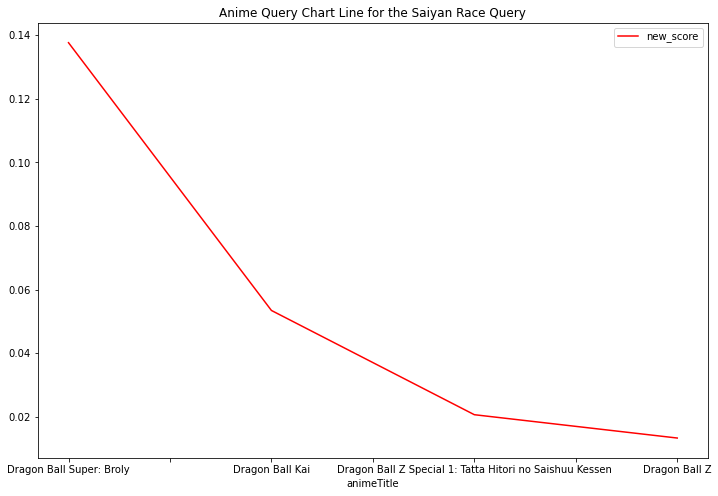

In [65]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# creating the plot
query_anime_df.plot(kind = 'line',
        x = 'animeTitle',
        y = 'new_score',
        color = 'red')
plt.rcParams["figure.figsize"] = (12,8)
plt.title('Anime Query Chart Line for the Saiyan Race Query')


The two tests sometimes give the same output respect to same queries.</br>
While sometimes, with the same query being input, results vary.</br>
Thats because, some animes doesnt have high cosine similarity and tfidf score, </br> 
but they relatively have high popularity and score.</br>
So that phenomena causes sometimes to give different results then normal cosine and tfidf test. As shown below</br>

For example, the test_query1 and test_query2 has the same input which is 'saiyan race'</br>
Similarity sorting is exactly the same, because animes are the same type (Dragon Ball)</br>
And probably they have the same anime fanbase. So that means that, general idea over the animes </br>
Will stay the same. If popularity is high, vote score will be high, and also tfidf and cosine similarity.</br>
Because saiyan race is only relateble to dragon ball anime, in this case total similarity and popularity, voting calculating</br>
Won't make that much of a difference. As shown below.

In [84]:
test_query1

,animeTitle,animeDescription,Url,similarity
3,Dragon Ball Super: Broly,"Forty-one years ago on Planet Vegeta, home of ...",https://myanimelist.net/anime/36946/Dragon_Bal...,0.018094
1,Dragon Ball Kai,"Five years after the events of Dragon Ball, ma...",https://myanimelist.net/anime/6033/Dragon_Ball...,0.006454
0,Dragon Ball Z Special 1: Tatta Hitori no Saish...,"Bardock, Son Goku's father, is a low-ranking S...",https://myanimelist.net/anime/986/Dragon_Ball_...,0.002246
2,Dragon Ball Z,Five years after winning the World Martial Art...,https://myanimelist.net/anime/813/Dragon_Ball_Z\n,0.001686


In [70]:
test_query2

,animeTitle,animeDescription,Url,new_score
3,Dragon Ball Super: Broly,"Forty-one years ago on Planet Vegeta, home of ...",https://myanimelist.net/anime/36946/Dragon_Bal...,0.137620
1,Dragon Ball Kai,"Five years after the events of Dragon Ball, ma...",https://myanimelist.net/anime/6033/Dragon_Ball...,0.053426
0,Dragon Ball Z Special 1: Tatta Hitori no Saish...,"Bardock, Son Goku's father, is a low-ranking S...",https://myanimelist.net/anime/986/Dragon_Ball_...,0.020647
2,Dragon Ball Z,Five years after winning the World Martial Art...,https://myanimelist.net/anime/813/Dragon_Ball_Z\n,0.013312


But when we come to see the test2_query1 and test2_query2. There is a different story. </br>
All of the animes are different and they vary. At the same time in the test2_query2 there is another anime.</br>
Why?</br>
Because we are only taking the top5 anime, and based on sorting, anime 'Big Wars: Kami...' has the higher score </br>
On total votes and popularity. Even with the query, its as not related as anime 'Keishichou Tokumubu...' in the test2_query1</br>
The query2 anime eliminated the first one based on our scoring system. Mushramboo on the other hand, was the 2nd highest </br>
As in similarity score, but within are new defined score system, rose up to 1st place because of the popularity and voting </br>
advantage which has over 'kekkaishi' </br>
We think that our scoring system is better chosing those are more related because </br>
As we can see in the real world, the more the site is clicked, the higher chance of recommendation it will get. </br>
For the animes, popularity and voting score is the two core indications about how many people watched it and liked it. </br>
So with cosine similarity and tfidf score, we also prioritized the popularities and scores of the animes.

In [97]:
test2_query1

,animeTitle,animeDescription,Url,similarity
168,Kekkaishi (TV),"Yoshimura Sumimura comes from a long line of ""...",https://myanimelist.net/anime/1606/Kekkaishi_TV\n,0.033711
10,Mushrambo,"In the world of Mushrambo, human life has all ...",https://myanimelist.net/anime/1137/Mushrambo\n,0.027842
191,Kuang Shen Mo Zun,"Long ago, one of the supreme beings in the hea...",https://myanimelist.net/anime/48942/Kuang_Shen...,0.025628
94,Halo Legends,Halo Legends features seven different stories ...,https://myanimelist.net/anime/6867/Halo_Legends\n,0.023125
185,Keishichou Tokumubu Tokushu Kyouakuhan Taisaku...,"In Tokyo, there exists a peaceful cohabitation...",https://myanimelist.net/anime/39567/Keishichou...,0.020747


In [112]:
test2_query2

,animeTitle,animeDescription,Url,new_score
10,Mushrambo,"In the world of Mushrambo, human life has all ...",https://myanimelist.net/anime/1137/Mushrambo\n,0.245430
4,Youma,"A terrible war has ravaged the land, and now, ...",https://myanimelist.net/anime/1484/Youma\n,0.217080
168,Kekkaishi (TV),"Yoshimura Sumimura comes from a long line of ""...",https://myanimelist.net/anime/1606/Kekkaishi_TV\n,0.195501
94,Halo Legends,Halo Legends features seven different stories ...,https://myanimelist.net/anime/6867/Halo_Legends\n,0.158763
74,Big Wars: Kami Utsu Akaki Kouya ni,It is the dawn of the 21st century. Mankind ha...,https://myanimelist.net/anime/2622/Big_Wars__K...,0.138097


# 5. Algorithmic question

**Disclamair**: we took and adapted some of the following coding ideas from https://www.geeksforgeeks.org/k-maximum-sums-non-overlapping-contiguous-sub-arrays/ and also from the discussions on
https://www.hackerrank.com/challenges/maximum-subarray-sum/problem.

Consult for managing back-to-back sequences of requests for appointments. A sequence of requests is of the form `[30, 40, 25, 50, 30, 20]` where each number is the time that the person who makes the appointment wants to spend. Aaccept some requests with a break between them. Two consecutive requests are not accepptable. 

For example, `[30, 50, 20]` is an acceptable solution (of duration 100), but `[30, 40, 50, 20]` is not, because 30 and 40 are two consecutive appointments. 

**Goal**: provide a schedule that maximizes the total length of the accepted appointments. Provide also:
- an algorithm that computes the acceptable solution with the longest possible duration;
- a program that given in input an instance in the form given above, gives the optimal solution

For example, in the previous instance, the optimal solution is `[40, 50, 20]`, of total duration 110.

## Formalization of the problem

Given an array of positive integers, find the maximum sum of all the subsequences with the constraint that no two numbers in the subsequences are adjacent in the array and return both the maximum sum and the subsequence(s) that realize the maximum sum. If $f=f(v)$ is the function we want to implement and $v=(30, 40, 25, 50, 30, 20)$, then we should have $f(v)=(40, 50, 20)$ with sum $s=110$, as in the example above.

**Algorithmic idea: Dynamic programming**. Given an array $v$, let $v^*[i]$ be the optimal solution using the elements with indices $0,..,i$. In order to have a recursive algorithm that terminates set $v^*[0] = v[0]$, and $\max(v[0],v[1])=0$, then $v^*[i] = \max(v^*[i - 1], v^*[i - 2] + v[i])$ for $i = 1, ..., n$ (where $n$ is the dimension of the array given in input). Clearly $v^*[n]$ is the solution we want and it is obteined in $O(n)$. We can then use another array to store which choice is made for each subproblem, and so recover the actual elements chosen.

The same idea can be used to solve a more general problem as shown in the examples at the end of this paragraph.

*Example* . Let $v=(1,2,2,10,1)$ and consider the matrix \begin{pmatrix} 1 & 0+2=2 & \dots & 12 & 4 \\ 0 & \max(0,1)=1 & \dots &3 & 12  \end{pmatrix}

then the maximum subsequence with no adjecent elements sum is 12 and the elements that realize it are (2,10)

### Code

In [387]:
# allows to initialize dictionaries with a lambda function 
# and provides the default value for a nonexistent key.
# so a defaultdict will never raise a KeyError.
from collections import defaultdict

In [388]:
def solution(array):
    # to track sums
    sums = [0]*len(array)
    
    # to track elements of the input array
    # example: if array = [1,2,3,5,4] at the emd of the following for loop
    # elements = {(0, 1): 1, (0, 2): 2, (1, 3): 4, (2, 5): 7, (4, 4): 8}
    elements = defaultdict(lambda: -1)
    
    for i in range(len(array)):
        # calculate maximum sum 
        sums[i] = max(sums[i-1], sums[i-2] + array[i])
        # memorize
        if max(sums[i-1], sums[i-2] + array[i])- (sums[i-2] + array[i]) == 0:
            elements[sums[i-2], array[i]] = sums[i]
    
    # retrieve elements that produce the optimal solution
    optimal_subarray = []
    
    # initialization
    max_value = max(elements.values())
    count = list(elements.keys())[list(elements.values()).index(max_value)][0]
    
    
    # to print the optimal subarray
    # example: if elements = {(15, 11): 26} it means that 15 is the cumulative sum
    # in this case 15 = 2+5+4+4 and (2,5,4) is the optimal solution, and 11 is the optimal subsequence sum
    # the values stored in the second index are those we need, and the first index we use it to check
    # when there are no more elements (i.e. count = 0)
    while count != 0:
        optimal_value = list(elements.keys())[list(elements.values()).index(max_value)][1]
        cum_sum = list(elements.keys())[list(elements.values()).index(max_value)][0]
        # put an element that realizes the optimal solution to the list
        optimal_subarray.insert(0,optimal_value)

        max_value = cum_sum
        count = cum_sum

    
    return optimal_subarray, sums[-1]

### Some examples

In [390]:
solution([1,2,2,10,1])

([2, 10], 12)

In [391]:
solution([1,2,3,5,4,4])

([2, 5, 4], 11)

In [392]:
solution([30, 40, 25, 50, 30, 20])

([40, 50, 20], 110)

### Solution of a generalization of the previous problem

**Attention:** the following code needs refinement. For example it works poorly in some test cases (e.g. when in the array there are duplicate elements or a lot of contiguous elements)

In [393]:
dd = defaultdict(lambda: -1)
prefix_sum = []
trace = []

In [394]:
def sub_array_sum(i, j):
    """
    Input: indexes i,j of an array v with i<j
    Output: v[i]+v[i+1]+...+v[j-1]+v[j]
    Remark: if i>j returns 0
    """
    if i == 0:
        return prefix_sum[j]
    return (prefix_sum[j] - prefix_sum[i - 1])

In [395]:
def maximum_sum(cur, v, k):
    """
    Input: current element cur, array v, positive integer k 
    Output: current maximum sum 
    Remark: this function allows also track the elements that realise the maximum sum.      
    """
    if cur >= len(v):
        return 0
    if dd[cur] != -1:
        return dd[cur]
    
    # use the following line when all the elements in the array are positive, 
    # else set s1 and s2 to -Infinity
    s1 = -1; s2 = -1
    
    # choose subarray starting at the current element "cur"
    if cur + k - 1 < len(v):
        # Remark: sub_array_sum(cur,cur)=0
        s1 = sub_array_sum(cur, cur + k - 1) + maximum_sum(cur + k + 1, v, k)
    
    # ignore subarray starting at "cur"
    s2 = maximum_sum(cur + 1, v, k)
    dd[cur] = max(s1, s2)
    
    if s1 >= s2:
        # keep track of the elements that realise the maximum sum
        trace[cur] = (True, cur + k + 1)
        return s1
    trace[cur] = (False, cur + 1)
    
    return s2

In [396]:
def sub_array(v, trace, k):
    """
    Input: array v, array trace, positive integer k 
    Output: optimal solution, i.e. optimal subarray
    Remark: this function allows to return non-consecutive subarrays of size k 
            for every positive integer k, but in our problem only the case 
            k=1 is of interest.
    """
    i = 0
    subArrays = []
    for i in range(len(trace)):
        if trace[i][0]:
            subArrays.append(v[i : i + k])
        i = trace[i][1]

    return subArrays

In [397]:
def generalized_solution(v, k):
    """
    Input: array v, positive integer k 
    Output: optimal solution, i.e. optimal subarray(s)
    Remark: this function allows to return non-consecutive optimal subarray(s) of size k 
            for every positive integer k, but in our problem only the case 
            k=1 is of interest.
    """
    global dd, trace, prefix_sum
    dd = defaultdict(lambda: -1)
    
    # initialization
    trace = [(False, 0)] * len(v)
    prefix_sum = [0] * len(v)
    prefix_sum[0] = v[0]
    
    for i in range(1,len(v)):
        prefix_sum[i] += prefix_sum[i - 1] + v[i]
        
    print("Array :", v)
    print("Max sum: ", maximum_sum(0, v, k))
    print("Subarrays: ", sub_array(v, trace, k))

### Some examples of solution of a more general problem

To sole a generalized version of the problem take $k>1$, as shown below

In [399]:
generalized_solution([1,2,3,4,5], 1)

Array : [1, 2, 3, 4, 5]
Max sum:  9
Subarrays:  [[1], [3], [5]]


In [400]:
generalized_solution([1,2,3,4,5], 2)

Array : [1, 2, 3, 4, 5]
Max sum:  12
Subarrays:  [[1, 2], [4, 5]]


In [401]:
generalized_solution([1,2,3,4,5], 3)

Array : [1, 2, 3, 4, 5]
Max sum:  12
Subarrays:  [[3, 4, 5]]


### Alternative solution

With immense surprise we have found that it is possible to solve the problem with just 3 lines of code! See https://codegolf.stackexchange.com/questions/183390/maximum-summed-subsequences-with-non-adjacent-items?answertab=active#tab-top for more deatils. 

Here it is the solution. 

In [403]:
v = [30, 40, 25, 50, 30, 20]
k = 1

In [404]:
f=lambda a:a and max([a[:1],a[:1]+f(a[2:]),f(a[1:])],key=sum)or a
for a, s in [(v, k)]:
    print(f(a), sum(f(a)))

[40, 50, 20] 110


In [405]:
v = [1, 2, 3, 5, 4]
k = 1

In [406]:
f=lambda a:a and max([a[:1],a[:1]+f(a[2:]),f(a[1:])],key=sum)or a
for a, s in [(v, k)]:
    print(f(a), sum(f(a)))

[1, 3, 4] 8


**Credits**: Chas Brown https://codegolf.stackexchange.com/users/69880/chas-brown